# ABC-SMC
## Approximate Bayesian Computation - Sequential Monte Carlo
Jakub Gwóźdź i Julia Żur

## Wstęp teoretyczny
<img src='what-is-abc.png'>

~ Sunnåker

#### Twierdzenie Bayesa
$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$
#### Motywacja
Założenia:  
&nbsp;&nbsp;&nbsp;&nbsp; A ->  $\theta$ (parametr modelu)   
&nbsp;&nbsp;&nbsp;&nbsp; B -> D (dane)
<br><br>
$P(\theta|D) = \frac{P(D|\theta)P(\theta)}{P(D)}$
    <br><br>
$P(\theta|D)$ - posterior <br>
$P(D|\theta)$ - likelihood <br>
$P(\theta)$ - prior ~ co uważamy o $\theta$ zanim mamy D, rozkład <br>
$P(D)$ - evidence ~ czynnik normalizujący, można go pominąć, gdy szukamy relacji <br>
<br>
$P(D|\theta)$ - trudne, czasochłonne, czasami niemożliwe do obliczenia dokładnie
<br>
Stąd ABC nazywane jest też likelihood free inference methods, bo nie ma potrzeby dokładnie obliczać czynnika prawdopodobieństwa.
#### Kiedy tak się dzieje?
Mamy dane eksperymentalne, ale nie znamy wszystkich parametrów wpływających na wynik, bo np. są one niemożliwe do zaobserwowania i/lub zupełnie losowe. <br>
Przykład: systemy biologiczne np. rozrost komórek rakowych, nie jesteśmy w stanie dokładnie określić, jak szybko komórki będą się rozrastać, bo nie znamy dokładnie wszystkich czynników na to wpływających.

#### Jak działa ABC?
<img src='./ABC-how-it-works.png'>

### ABC-SMC -> Approximate Bayesian Computation - Sequential Monte Carlo
> Sequential monte carlo ABC to metoda, która iteracyjnie modyfikuje $P(\theta)$
 (prior) w $P(\theta|D)$ (posterior) poprzez propagację próbek parametru $\theta$ przez szereg proponowanych dystrybucji $\phi(\theta^{(i)})$ (np. Gaussa) stosując wagi do parametru $\theta^{(i)}$ w taki sposób, że:
 <br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\omega(i) ∝ \frac{P(\theta^{(i)})}{\phi(\theta^{(i)})} $
 <br>Jeśli przyjmiemy, że $\beta$ to parametr kontrolujący:
 <br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $P(\theta|D)_{\beta} ∝ P(D|\theta)^{\beta}P(\theta)$ 
 <br> Zauważmy, że jeśli $\beta = 0$ to $P(\theta|D) ∝ P(\theta)$, czyli startujemy od dystrybucji prior i w każdym kroku wprowadzamy próbki z $P(D|\theta)$.<br>
 Wynikiem jest zbiór próbek z dystrybucji tzw. posterior.
 
 SMC pozwala na próbkowanie funkcji posiadających wiele szczytów.
 
 <img src='smc.png'>

### Estymacja parametrów
 <img src='abc_smc.png'>

### Wybór optymalnego modelu

<img src='./abc_smc_model.png'> 

## Instalacja biblioteki PyABC

In [1]:
!pip install pyabc==0.10.10

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tempfile
import random
import itertools
import pyabc
from collections import Counter

## Funkcje pomocnicze

In [22]:
def plot_history(history):
    _, arr_ax = plt.subplots(2, 2)

    pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
    pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
    pyabc.visualization.plot_credible_intervals(
        history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
        show_mean=True, show_kde_max_1d=True, arr_ax=arr_ax[1][0])
    pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

    plt.gcf().set_size_inches((12, 8))
    plt.gcf().tight_layout()

def plot_comparison(mu, sigma):
    simulation = gaussian_simulation({'mu': mu, 'sigma': sigma})['data']
    fig, ax = plt.subplots(1, 1)
    ax.hist(simulation, density=True, histtype='stepfilled', alpha=0.5, label='model')
    ax.hist(data, density=True, histtype='stepfilled', alpha=0.5, label='data')
    ax.legend(loc='best', frameon=False)
    plt.show()

def plot_double_comparison(mu_1, sigma_1, mu_2, sigma_2, f_h_samples):
    simulation = double_gaussian_simulation({
        'mu_1': mu_1,
        'sigma_1': sigma_1,
        'mu_2': mu_2,
        'sigma_2': sigma_2,
        'f_h_samples': f_h_samples
    })['data']
    sim_hist = get_hist(simulation)
    data_hist = get_hist(double_data)
    fig, ax = plt.subplots(1, 1)
    ax.bar(possible_keys, sim_hist, label="model", alpha=0.5)
    ax.bar(possible_keys, data_hist, label="data", alpha=0.5)
    ax.legend(loc='best', frameon=False)
    plt.show()
    
def plot_posterior(history, name):
    if name == 'danceability':
        mu_min, mu_max = 0, 1.5
        sigma_min, sigma_max = 0, 1.5
    elif name == 'loudness':
        mu_min, mu_max = -10, -2.5
        sigma_min, sigma_max = 1.5, 4.5
    else:
        mu_min, mu_max = -10, 10
        sigma_min, sigma_max = 0, 10
    fig = plt.figure(figsize=(15, 10))
    ax_mu = fig.add_subplot(221)
    for t in range(history.max_t+1):
        df_h, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df_h, w,
            xmin=mu_min, xmax=mu_max,
            x="mu", ax=ax_mu,
            label="t={}".format(t))
    ax_mu.legend();
    ax_sigma = fig.add_subplot(222)
    for t in range(history.max_t+1):
        df_h, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df_h, w,
            xmin=sigma_min, xmax=sigma_max,
            x="sigma", ax=ax_sigma,
            label="t={}".format(t))
    ax_sigma.legend();
    
def all_steps_ABC_SMC(smc_posterior):
    eps = []
    for i in smc_posterior:
        eps.append(i['epsilon'])
        mu = i[0][0]

        mukde = st.gaussian_kde(mu)

        plt.figure(figsize=(15,3))
        plt.subplots_adjust(wspace=0.4)
        plt.subplot(121)
        x = np.linspace(-2,2,1000)
        y = [mukde(val) for val in x]
        plt.suptitle(r'$\epsilon$ = {:.3f}, $\mu$ = {:.3f}'.format(i['epsilon'], x[y.index(max(y))]))
        plt.plot(x, y)
        plt.axvline(theta0, ls='--')
        plt.ylim(0,5)
        plt.xlim(-2,2)
        plt.xlabel(r"$\mu$", fontsize=30)

        plt.subplot(122)

        plt.plot(eps,'-o')
        plt.xlabel('Step', fontsize=24)
        plt.ylabel(r'$\epsilon$', fontsize=30)
        plt.xlim(-1,15)
        plt.ylim(0,1)
        
def last_step_ABC_SMC(posterior, steps=1):    
    mu = posterior[steps-1][0]

    mukde = st.gaussian_kde(mu)

    plt.figure(figsize=(15,6))
    plt.subplots_adjust(wspace=0.2)
    plt.subplot(111)
    x = np.linspace(-2,2,1000)
    y = [mukde(val) for val in x]
    plt.suptitle(r'$\epsilon$ = {:.3f}, $\mu$ = {:.3f}'.format(posterior[1][-1], x[y.index(max(y))]))
    plt.plot(x, y)
    plt.axvline(theta0, ls="--")
    plt.xlabel(r"$\mu$", fontsize=30)
    plt.ylim(0,5)
    plt.xlim(-2,2)
    
def ABC_SMC_step_over_data(posterior, data, step=0):
    mu = posterior[step][0]
    data_mu = np.mean(data)
    sigma = np.std(data)
    
    mukde = st.gaussian_kde(mu)

    c = Counter(data)
    
    plt.figure(figsize=(15,6))
    x = np.linspace(data_mu - 3*sigma, data_mu + 3*sigma, len(list(c.values())))
    x_sim = np.linspace(-1,2,1000)
    plt.plot(x_sim, mukde(x_sim), 'r', label='simulation')
    
    data_y = np.array([c[d] for d in sorted(list(c.keys()))])

    plt.bar(x, data_y/np.max(data_y), label='data')
    plt.legend()
    plt.show()

# Dane
Informacje o piosenkach w serwisie Spotify:

https://www.kaggle.com/mrmorj/dataset-of-songs-in-spotify?select=genres_v2.csv

In [4]:
df = pd.read_csv('genres.csv')
df.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,Unnamed: 0,title
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,...,2Vc6NJ9PW9gD9q343XFRKx,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...,https://api.spotify.com/v1/audio-analysis/2Vc6...,124539,4,Dark Trap,Mercury: Retrograde,NaN,NaN
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,...,7pgJBLVz5VmnL7uGHmRj6p,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...,https://api.spotify.com/v1/audio-analysis/7pgJ...,224427,4,Dark Trap,Pathology,NaN,NaN
2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,0.3720,0.0391,...,0vSWgAlfpye0WCGeNmuNhy,spotify:track:0vSWgAlfpye0WCGeNmuNhy,https://api.spotify.com/v1/tracks/0vSWgAlfpye0...,https://api.spotify.com/v1/audio-analysis/0vSW...,98821,4,Dark Trap,Symbiote,NaN,NaN
3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,...,0VSXnJqQkwuH2ei1nOQ1nu,spotify:track:0VSXnJqQkwuH2ei1nOQ1nu,https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...,https://api.spotify.com/v1/audio-analysis/0VSX...,123661,3,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),NaN,NaN
4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,...,4jCeguq9rMTlbMmPHuO7S3,spotify:track:4jCeguq9rMTlbMmPHuO7S3,https://api.spotify.com/v1/tracks/4jCeguq9rMTl...,https://api.spotify.com/v1/audio-analysis/4jCe...,123298,4,Dark Trap,Venom,NaN,NaN


In [5]:
df['danceability'].describe()

count    42305.000000
mean         0.639364
std          0.156617
min          0.065100
25%          0.524000
50%          0.646000
75%          0.766000
max          0.988000
Name: danceability, dtype: float64

In [6]:
df['loudness'].describe()

count    42305.000000
mean        -6.465442
std          2.941165
min        -33.357000
25%         -8.161000
50%         -6.234000
75%         -4.513000
max          3.148000
Name: loudness, dtype: float64

# Algorytm ABC-SMC

Algorytm ABC-SMC:

   0. Stwórz funkcję dystansu odpowiednią dla zadanego modelu.
   1. Pobierz próbki z rozkładu parametru $\alpha$ (prior distribution) wykorzystując metodę SMC.
   2. Dla każdej próbki z punktu 1 stwórz symulację wykorzystując model, który zwraca zbiór danych o takim samym rozmiarze jak dane z obserwacji.
   3. Porównaj dane wynikowe z punktu 2 z danymi z obserwacji wykorzystując funkcję dystansu z punktu 0.
   4. Znajdź te dystrybucje, dla których funkcja dystansu zwraca wartość  $\leq \epsilon$.
   5. Stwórz nową, poprawioną dystrybucję parametru $\alpha$.

### Model Gaussa

Posiada on dwa parametry $\mu$ - wartość oczekiwana (położenie najwyższego punktu) oraz $\sigma$ - odchylenie standardowe (szerokość podstawy): $N(\mu,\sigma^2)$ . <br> 

Zawsze wymagane jest zdefiniowanie dla modelu dwóch funkcji: 
* funkcja distance_function - obliczanie różnicy pomiędzy modelem a symulacją
* funkcja summary_stats - zwraca parametry danych, które chcemy estymować



### Spróbujemy dokonać estymacji parametru $\mu$ na danych dotyczących _danceability_.
### ZADANIE 1

Uzupełnić kod funkcji distance_function oraz summary_stats.

In [7]:
class GaussianModel:

    
    # ZAD 1.1 - Funckja dystansu, chcemy użyć odległości Euklidesowej
    def distance_function(self, data, synthetic_data):
        return np.abs(data - synthetic_data)
    
    # ZAD 1.2 - Zwraca parametry modelu do estymacji dla zadanych danych, tutaj tylko wartość oczekiwaną mu
    def summary_stats(self, data):
        mu = np.mean(data)
        return (mu)
    
    # Generowanie danych, loc - wartość oczekiwana, scale - odchylenie standardowe
    def generate_data(self, theta, sigma=1):
        return st.norm.rvs(loc=theta, scale=sigma, size=self.data_size)
    
    # Funkcja zwracająca rozkład prior przy pierwszym kroku
    def draw_theta(self):
        theta = []
        for p in self.prior:
            theta.append(p.rvs())
        return theta
    
    # SETTERY
    
    def set_data(self, data):
        self.data = data
        self.data_sum_stats = self.summary_stats(self.data)
        self.data_size = len(data)
        
    def set_prior(self, prior):
        self.prior = prior

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

### ABC
Funkcja ABC zajmuje się próbkowaniem i generowaniem symulacji. Następnie oblicza odległość między symulacją a danymi i na podstawie zadanego progu błędu $\epsilon$ decyduje, czy zaakceptować dany rozkład.

* model - klasa modelu, musi zawierać funkcje distance_function, summary_stats, generate_data oraz draw_data
* data - dane oryginalne
* epsilon - próg błędu
* min_samples - wymagana ilość zaakceptowanych próbek
* smc_mode - czy wykorzystywany jest algorytm SMC


Poniższe parametry są istotne tylko przy wykorzystaniu SMC:

* weights - wagi rozkładów
* theta_prev - poprzedni rozkład
* tau_squared - wariancje rozkładów

### ZADANIE 2

Uzupełnić tworzenie symulacji i obliczanie odległości między symulacją a danymi.

In [8]:
def ABC(model, data, epsilon=1, min_samples=10, smc_mode=False,
        weights='None', theta_prev='None', tau_squared='None'):

    posterior, distances = [], []
    trial_count, accepted_count = 0, 0
    
    # pobranie summary statistic z modelu, czyli parametrów do estymacji
    data_summary_stats = model.summary_stats(data)
        
    # próbkowanie metodą SMC powtarzane jest do uzyskania żądanej liczby próbek
    while accepted_count < min_samples:
        
        trial_count += 1
    
        if smc_mode:
            
            # Obcinamy próbki do tych, które mieszczą się w rozkładzie
            theta_star = theta_prev[:, np.random.choice(
                        range(0, theta_prev.shape[1]),replace=True, p=[weight/sum(weights) for weight in weights]
            )]
            
            # Tworzymy rozkład normalny o zadanej średniej i kowariancji oraz pobieramy losową próbkę, która zostaniem nowym mu
            theta = st.multivariate_normal.rvs(theta_star, tau_squared)
            if np.isscalar(theta) == True:
                theta = [theta]
    
        # pierwszy krok
        else:
            theta = model.draw_theta()
        
        # ZAD 2.1 - Stwórz symulację, odtwórz dane z użyciem funkcji generate_data z nowo wybranym mu
        
        simulation_data = model.generate_data(theta)

        # ZAD 2.2 - Oblicz summary statistics dla nowo utworzonych danych
        
        simulation_summary_stats = model.summary_stats(simulation_data)
        
        # ZAD 2.3 - Oblicz dystans pomiędzy summary statistic danych oryginalnych oraz z symulacji, 
        
        distance = model.distance_function(data_summary_stats, simulation_summary_stats)

        # jeżeli próbka jest zaakceptowana, zapisujemy ją
        if distance < epsilon:
            accepted_count += 1
            posterior.append(theta)
            distances.append(distance)

    posterior = np.asarray(posterior).T

    if len(posterior.shape) > 1:
        n = posterior.shape[1]
    else:
        n = posterior.shape[0]

    weights = np.ones(n)
    tau_squared = np.zeros((posterior.shape[0], posterior.shape[0]))
    
    return (posterior, distances,
            accepted_count, trial_count,
            epsilon, weights, tau_squared)

### SMC
Funckja ABC_SMC wykonuje algorytm ABC wielokrotnie. Zmienia się sposób próbkowania danych.

* epsilon0 - startowy próg błędu, w każdym kroku nowy próg jest obliczany
* steps - ile razy powtarzany jest algorytm

### ZADANIE 3
Uzupełnić wywołania funckji ABC z odpowiednimi parametrami.

In [9]:
def ABC_SMC(model, data, epsilon0=1, min_samples=10, steps=10):

    output_record = np.empty(steps, dtype=[('theta accepted', object),
                                           ('D accepted', object),
                                           ('n accepted', float),
                                           ('n total', float),
                                           ('epsilon', float),
                                           ('weights', object),
                                           ('tau_squared', object)
                                           ])
    
    steps = range(steps)
    epsilon = epsilon0
    
    for step in steps:
        
        print('Starting step ' + str(step))
        
        # jeżeli pierwszy krok to wykonujemy krok ABC bez SMC 
        if step == 0:

            # ZAD 3.1 - Wywołaj funkcję ABC tylko z parametrami potrzebnymi w pierwszym kroku, 
            # na razie bez trybu SMC
            output_record[step] = ABC(model, data, epsilon=epsilon,
                                            min_samples=min_samples, smc_mode=False)
            
            # zapisujemy do historii parametry dla każdego kroku
            theta = output_record[step]['theta accepted']
            
            # obliczamy kowariancję wartości oczekiwanej
            tau_squared = 2 * np.cov(theta)
            
            # inicjujemy wagi
            weights = np.ones(theta.shape[1]) * 1.0/theta.shape[1]
            
            # Obliczany jest percentyl 75, który zostaje nowym epsilonem w kolejnym kroku
            epsilon = st.scoreatpercentile(output_record[step]['D accepted'],
                                              per=75)

            output_record[step]['weights'] = weights
            output_record[step]['tau_squared'] = tau_squared
            
        # wykonujemy kolejny krok SMC
        else:
            
            # obliczone w każdym kroku theta i wagi przekazujemy jako parametry do ABC
            theta_prev = theta
            weights_prev = weights

            # ZAD 3.2 - Wywołaj funkcję ABC ze wszystkimi parametrami, pamiętaj o odpowiednim trybie SMC
            output_record[step] = ABC(model, data, epsilon=epsilon,
                                            min_samples=min_samples, smc_mode=True,
                                            weights=weights, theta_prev=theta_prev,
                                            tau_squared=tau_squared)
            
            # obliczamy nowe wartości mu oraz progu błędu
            theta = output_record[step]['theta accepted']
            epsilon = st.scoreatpercentile(output_record[step]['D accepted'], per=75)
            
            # zapisujemy parametry do historii
            output_record[step]['tau_squared'] = tau_squared
            output_record[step]['weights'] = weights
            
    return output_record

## Testowanie rozwiązania

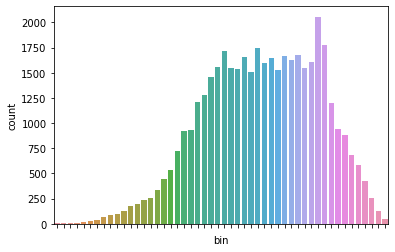

count    42305.000000
mean         0.639364
std          0.156617
min          0.065100
25%          0.524000
50%          0.646000
75%          0.766000
max          0.988000
Name: danceability, dtype: float64

In [10]:
df['bin'] = pd.cut(df['danceability'], bins=50).sort_values()
bar_danceability = sns.countplot(x=df['bin'])
bar_danceability.set(xticklabels=[])
plt.show()
df['danceability'].describe()

### Zbudowanie modelu
Parametry początkowe wpływają na szybkość działania modelu. Źle wybrane mogą spowodować zaburzenie wyników.

### ZADANIE 4
Pozmieniaj parametry epsilon0, min_samples oraz steps i zobacz jak zmienią wynik. 
W modelu ABC znaczenie mają epsilon0 - zbyt niski może długo się liczyć oraz min_samples - zbyt wysoki również może długo się liczyć. A w przypadku ABC-SMC również steps ma znaczenie - zbyt wysokie także spowoduje problemy (UWAGA! dla każdego kroku produkowany jest wykres).

In [11]:
theta0 = 0
sigma0 = 1

# ZAD 4.1 - Parametry do zmieniania
epsilon0 = 0.5
min_samples = 10
steps = 15

model = GaussianModel()
data = list(df['danceability'])

# Stworzenie pierwszego rozkładu prior ze startowymi wartościami parametrów
model.set_prior([st.norm(loc=theta0,scale=sigma0)])

model.set_data(data)

### Estymacja posterior przy użyciu tylko algorytmu ABC.

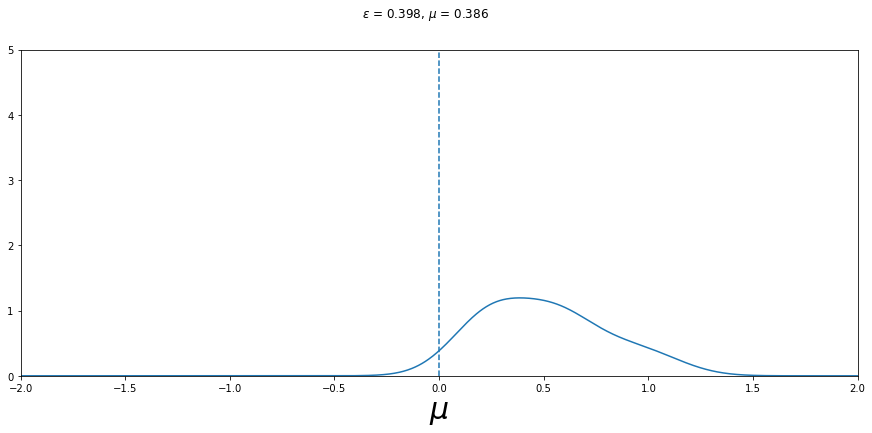

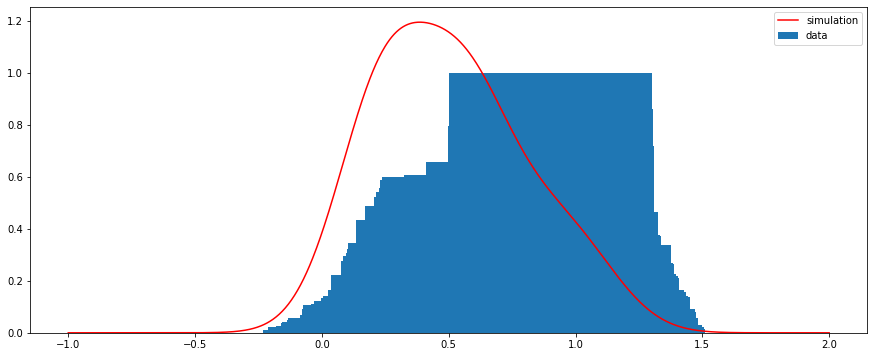

In [23]:
posterior = ABC(model, data, epsilon0, min_samples)
last_step_ABC_SMC(posterior) 
ABC_SMC_step_over_data(posterior, data)

### Estymacja krokowa posterior przy użyciu algorytmu ABC-SMC.

Starting step 0
Starting step 1
Starting step 2
Starting step 3
Starting step 4
Starting step 5
Starting step 6
Starting step 7
Starting step 8
Starting step 9
Starting step 10
Starting step 11
Starting step 12
Starting step 13
Starting step 14


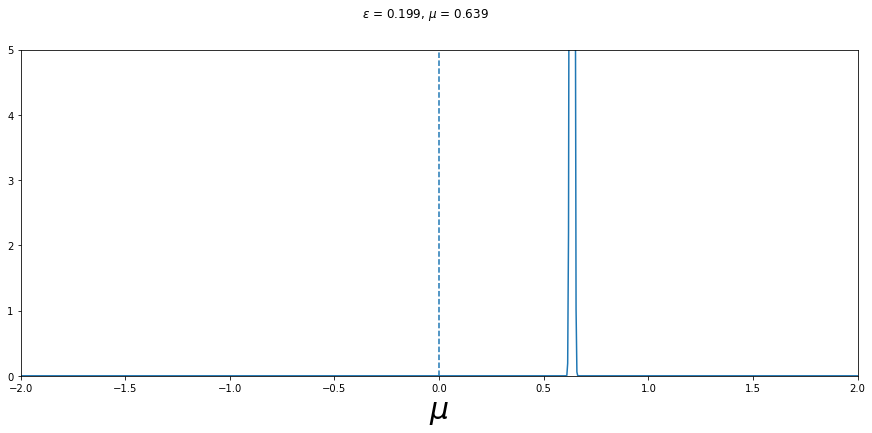

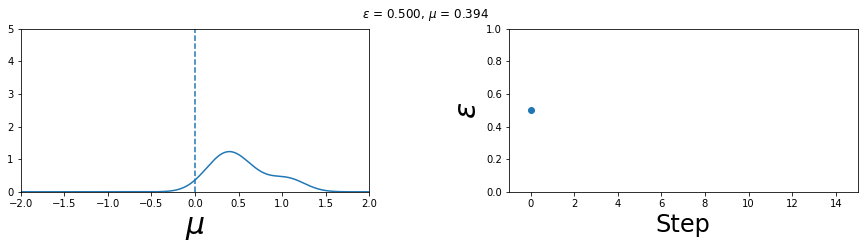

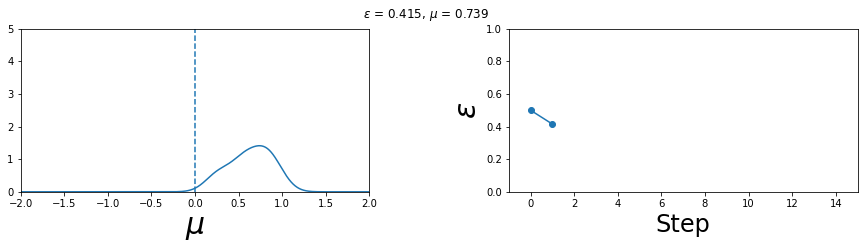

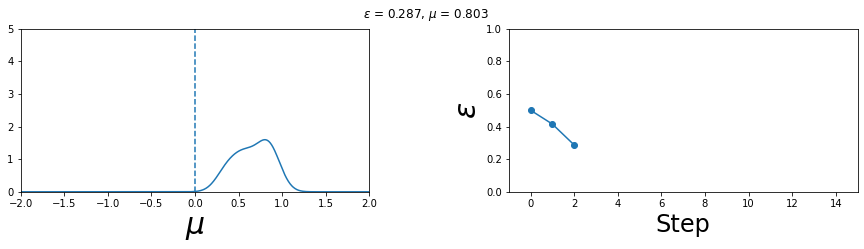

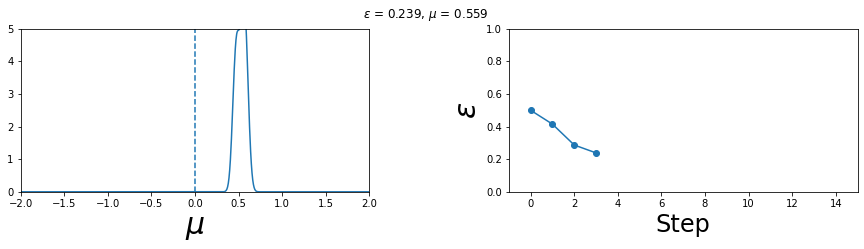

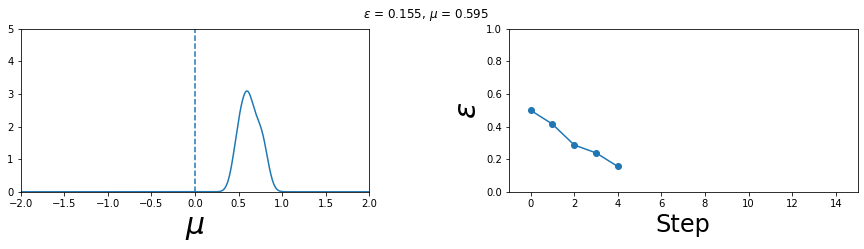

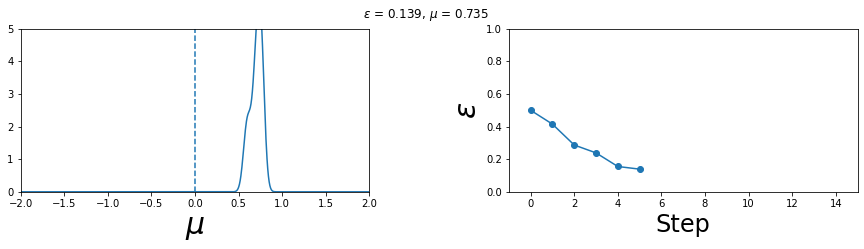

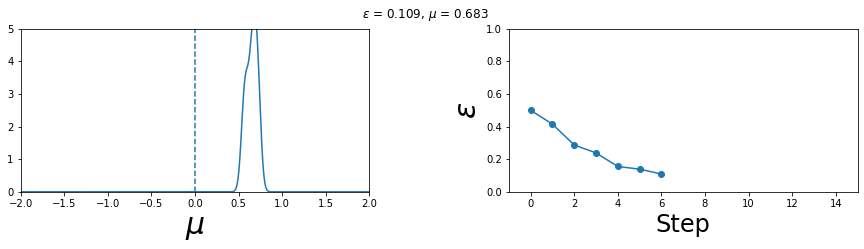

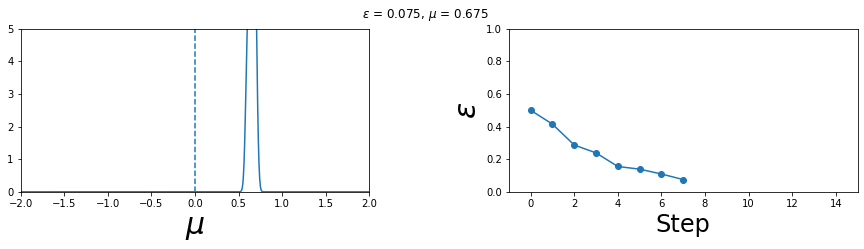

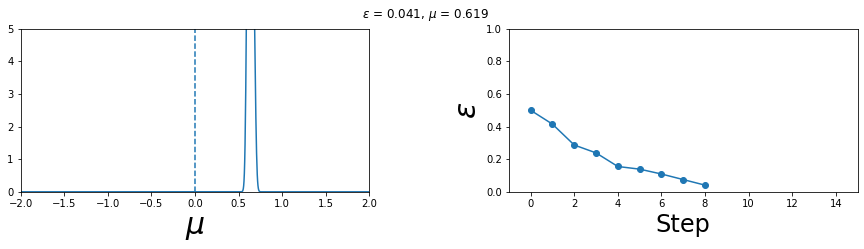

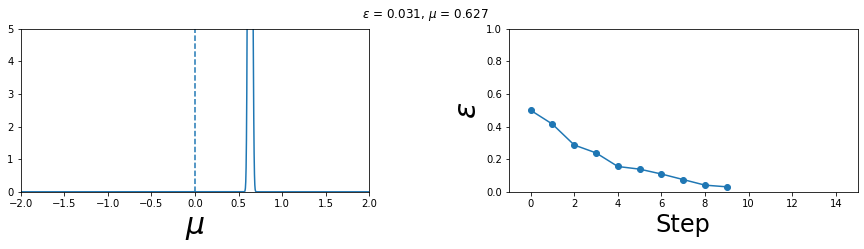

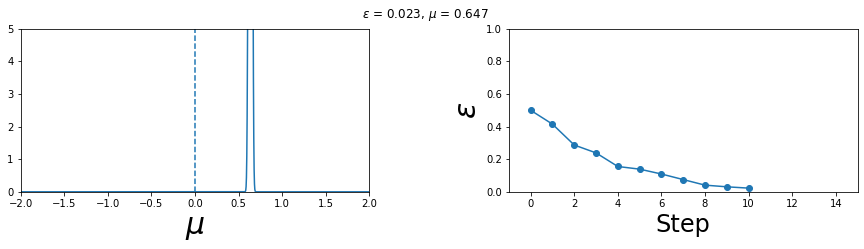

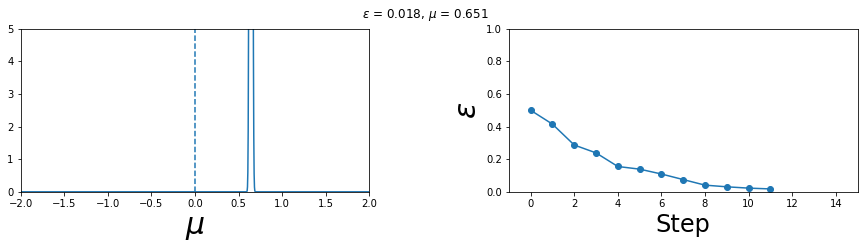

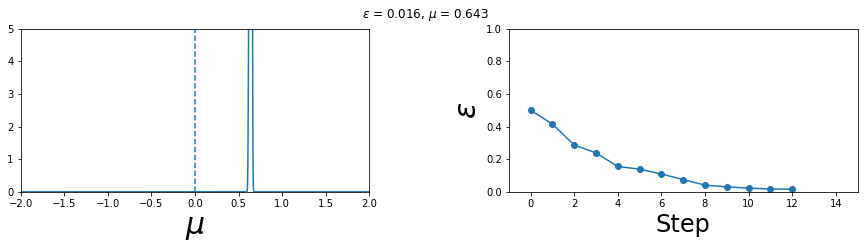

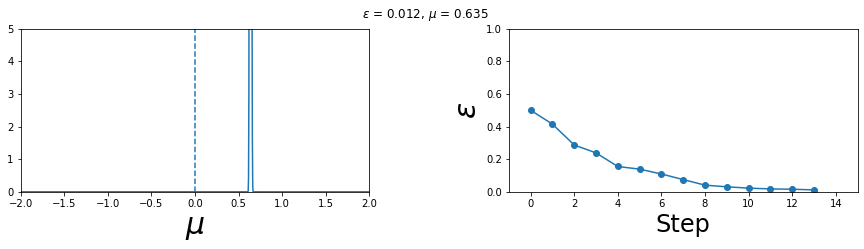

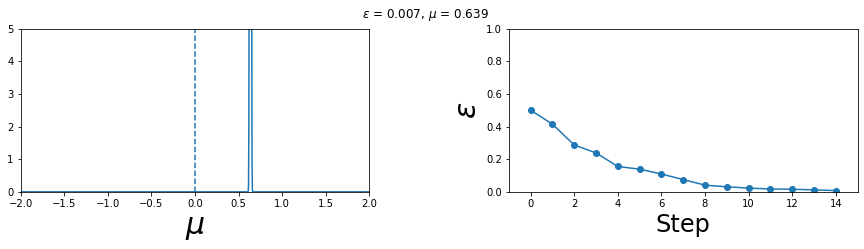

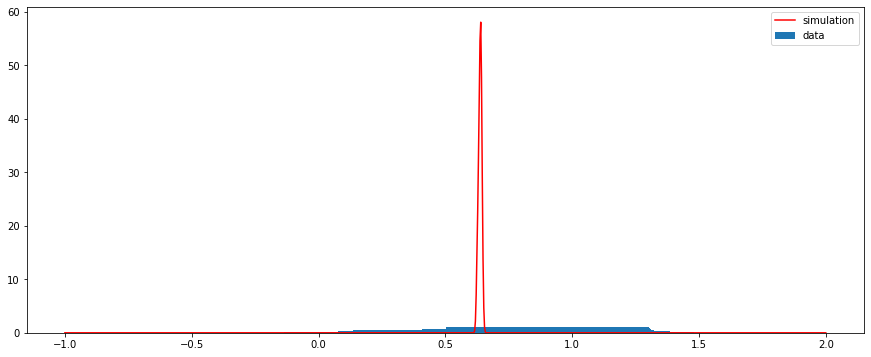

In [24]:
smc_posterior = ABC_SMC(model, data, epsilon0, min_samples, steps)
last_step_ABC_SMC(smc_posterior, steps)
all_steps_ABC_SMC(smc_posterior)
ABC_SMC_step_over_data(smc_posterior, data, step=steps-1)

# ABS-SMC przy użyciu biblioteki pyABC

Biblioteka również wymaga zdefiniowania modelu, a konkretnie funkcji get_stats i distance.

## Dopasowanie modelu Gaussa do danych

### ZADANIE 

In [14]:
def get_stats(data):
    return np.array([data.mean(), data.std()])

def distance(simulation, data):
    data_stats = get_stats(data["data"])
    simulation_stats = get_stats(simulation["data"])
    return np.mean(abs(simulation_stats - data_stats))

In [15]:
def gaussian_simulation(parameters):
    return {"data": st.norm.rvs(loc=parameters['mu'], scale=parameters['sigma'], size=n_samples)}

In [16]:
data, data_name = np.array(df.danceability), 'danceability'
# data, data_name = np.array(df.loudness), 'loudness'
n_samples = data.shape[0]

data_mu = data.mean()
data_sigma = data.std()

print(
    f'''
    DATA:
    \t mu: \t\t{data_mu}
    \t sigma: \t{data_sigma}
    '''
)


    DATA:
    	 mu: 		0.6393643210022456
    	 sigma: 	0.1566152732579436
    


In [17]:
# ---- DANCEABILITY ----
# eps = 0.1 (0.01 also works t ~ 9)
danceability_parameter_priors = [
    pyabc.Distribution(
        mu=pyabc.RV("uniform", 0.1, 0.9),
        sigma=pyabc.RV("uniform", 0.1, 0.9),
                      )
]

# ---- LOUDNESS ----
# eps = 0.1 with t ~ 8

loudness_parameter_priors = [
    pyabc.Distribution(
        mu=pyabc.RV("uniform", -10, 10),
        sigma=pyabc.RV("uniform", 0.1, 5),
                      )
]

In [18]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "tutorial.db"))
abc = pyabc.ABCSMC(gaussian_simulation, danceability_parameter_priors, distance)
abc.new(db_path, {"data": data});

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=10, start_time=2021-01-11 00:25:53.834725, end_time=None)>


In [19]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.2926662858009437
INFO:ABC:t: 0, eps: 0.2926662858009437.
INFO:ABC:Acceptance rate: 100 / 193 = 5.1813e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.19312345541601247.
INFO:ABC:Acceptance rate: 100 / 224 = 4.4643e-01, ESS=8.5170e+01.
INFO:ABC:t: 2, eps: 0.12072215520351398.
INFO:ABC:Acceptance rate: 100 / 216 = 4.6296e-01, ESS=9.5640e+01.
INFO:ABC:t: 3, eps: 0.07511379342552363.
INFO:ABC:Acceptance rate: 100 / 259 = 3.8610e-01, ESS=9.3097e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=10, start_time=2021-01-11 00:25:53.834725, end_time=2021-01-11 00:26:03.247960)>


In [20]:
mu = float(history.get_distribution()[0].tail(1).mu)
sigma = float(history.get_distribution()[0].tail(1).sigma)
print(
    f'''
    MODEL:
    \t mu: \t\t{mu}
    \t sigma: \t{sigma}
    DATA:
    \t mu: \t\t{data_mu}
    \t sigma: \t{data_sigma}
    '''
)


    MODEL:
    	 mu: 		0.6652955944863574
    	 sigma: 	0.23385460523568966
    DATA:
    	 mu: 		0.6393643210022456
    	 sigma: 	0.1566152732579436
    


KeyError: 'mu'

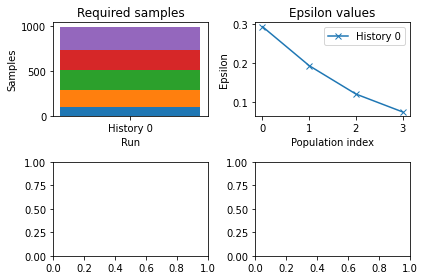

In [21]:
plot_history(history)

In [ ]:
plot_posterior(history, data_name)

In [ ]:
plot_comparison(mu, sigma)

## ZADANIE DODATKOWE

### Gauss z dwoma "górkami"

Uruchomić poniższy kod i zaobserwować wynik.

In [ ]:
sns.countplot(x="key", data=df)

In [ ]:
hists = []
def get_hist(data):
    c = Counter(data)
    hist = []
    for key in possible_keys:
        hist.append(c.get(key, 0))
    return np.array(hist)

def double_distance(simulation, data):
    data_stats = get_hist(data["data"])
    simulation_stats = get_hist(simulation["data"])
    hists.append({'sim': simulation_stats, 'data': data_stats})
    return np.mean(abs(simulation_stats - data_stats))

In [ ]:
def double_gaussian_simulation(parameters):
    second_heap_samples = n_double_samples - int(parameters['f_h_samples'])
    h1 = st.norm.rvs(loc=parameters['mu_1'], scale=parameters['sigma_1'], size=int(parameters['f_h_samples']))
    h2 = st.norm.rvs(loc=parameters['mu_2'], scale=parameters['sigma_2'], size=second_heap_samples)
    h1 = [max(0, min(int(h), possible_keys[-1])) for h in h1]
    h2 = [max(0, min(int(h), possible_keys[-1])) for h in h2]

    data = np.hstack([h1, h2])
#     data = [int(d) for d in data]

    return {"data": data}

In [ ]:
double_data = np.array(df.key)
n_double_samples = double_data.shape[0]
possible_keys = sorted(df.key.unique())

print(
    f'''
    DATA:
    \t mu_1: \t\t~ 1
    \t sigma_1: \t~ 1
    \t mu_2: \t\t~ 7
    \t sigma_2: \t~ 3
    '''
)

In [ ]:
# ---- KEY ----
# eps = 1000 t ~ 9
# eps = 900 t ~ 10
key_parameter_priors = [
    pyabc.Distribution(
        mu_1=pyabc.RV("uniform", 0, 4),
        sigma_1=pyabc.RV("uniform", 0, 3),
        mu_2=pyabc.RV("uniform", 3, 10),
        sigma_2=pyabc.RV("uniform", 0, 6),
        f_h_samples=pyabc.RV("uniform", 0, n_double_samples)
                      )
]


In [ ]:
abc = pyabc.ABCSMC(double_gaussian_simulation, key_parameter_priors, double_distance)
abc.new(db_path, {"data": double_data});

In [ ]:
history = abc.run(minimum_epsilon=700, max_nr_populations=15)

In [ ]:
mu_1 = float(history.get_distribution()[0].tail(1).mu_1)
sigma_1 = float(history.get_distribution()[0].tail(1).sigma_1)

mu_2 = float(history.get_distribution()[0].tail(1).mu_2)
sigma_2 = float(history.get_distribution()[0].tail(1).sigma_2)

f_h_samples = float(history.get_distribution()[0].tail(1).f_h_samples)
print(
    f'''
    MODEL:
    \t mu_1: \t\t{mu_1}
    \t sigma_1: \t{sigma_1}
    \t mu_2: \t\t{mu_2}
    \t sigma_2: \t{sigma_2}
    \t f_h_samples: \t{f_h_samples}
    '''
)

In [ ]:
plot_double_comparison(mu_1, sigma_1, mu_2, sigma_2, f_h_samples)

### Dla bardziej zainteresowanych, Źródła
https://www.nature.com/articles/npre.2011.5964.1 <br>
https://docs.pymc.io/notebooks/SMC-ABC_Lotka-Volterra_example.html <br>
https://en.wikipedia.org/wiki/Approximate_Bayesian_computation <br>
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3547661/ <br>
https://github.com/rcmorehead/simpleabc/blob/master/simple_abc.py <br>
https://clincancerres.aacrjournals.org/content/18/18/5071